In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random
from scipy import stats

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

C:\Users\Insight1\Anaconda3\envs\tf-gpu\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Load previous saved corpus file

In [2]:
data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl') #load data for tf-idf
data.columns

Index(['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year',
       'notes_split', 'len_notes', 'notes_clean', 'len_clean',
       'spacy_notes_clean', 'lss_notes', 'len_lss', 'lss_corpus',
       'spacy_lss_corpus'],
      dtype='object')

In [3]:
# os.chdir("C:\\Users\\Insight1\\Anaconda3")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (data['len_lss']<=2000) & (data['len_lss']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_tfidf = data[filt][['age', 'le','le_year','lss_notes','lss_corpus']]

corpus = data_tfidf['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf data most frequent 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

### Prepare data for model

In [4]:
X = corpus_tfidf.toarray()
x_age = np.expand_dims(data_tfidf['age'].to_numpy(), axis = 1)

# X y from tf-idf for Model
X = np.hstack((x_age, X))
y = data_tfidf['le'].to_numpy() 

### Multilayer Perceptron Model

In [5]:
print(X.shape,y.shape)

(53020, 4001) (53020,)


In [6]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

# # normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_val[:, 0] = (X_val[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.models.Sequential()

model.add(keras.Input(shape=4001,))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'normal'))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = 1))
model.summary()

model.compile(optimizer= 'adam',loss = 'mean_squared_error')

checkpoint_filepath = '/log'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=10000, epochs=1000, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

print(history.history.keys())
model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

from sklearn.metrics import mean_absolute_error
abs_er = mean_absolute_error(y_test, y_test_nn)
print(abs_er)

from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_train_nn)
rsq_val = r2_score(y_val, y_val_nn)
rsq_test = r2_score(y_test, y_test_nn)

print(rsq_train, rsq_val, rsq_test)
# model prediction from medical notes without age 
# 100 epoches: abs_er= 19.991914022416207; rsq_test =0.6311475230416835; rsq_train = 0.9392278263642062 
# 20.781554059329675
# 0.6444936458044239 0.5632780303898981 0.5536371000303386

#3000 epoch (512/256/512) abs=23.203737412144314  r2 = 0.768495009799099  0.5852656900697112 0.5530109538595611
#3000 epoch (512/0.3,256/0.3, 512)abs=20.688904906315482 r2 =0.9325278290184188 0.6484640725710789 0.61039924081627


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1024512   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

37114/37114 [==============================] - 1s 33us/sample - loss: 6879.1136 - val_loss: 9299.4824
Epoch 60/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6819.7187 - val_loss: 9164.8008
Epoch 61/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6757.9339 - val_loss: 8987.2441
Epoch 62/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6692.8983 - val_loss: 8757.5996
Epoch 63/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6627.8483 - val_loss: 8543.6377
Epoch 64/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6563.0157 - val_loss: 8406.7773
Epoch 65/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6499.1653 - val_loss: 8246.4160
Epoch 66/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 6432.7091 - val_loss: 8071.2969
Epoch 67/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 63

37114/37114 [==============================] - 1s 32us/sample - loss: 1862.2064 - val_loss: 1867.1879
Epoch 130/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1801.6955 - val_loss: 1829.9093
Epoch 131/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1753.1152 - val_loss: 1773.6122
Epoch 132/1000
37114/37114 [==============================] - 1s 30us/sample - loss: 1693.4656 - val_loss: 1716.3048
Epoch 133/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1645.9828 - val_loss: 1669.2806
Epoch 134/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1591.4474 - val_loss: 1591.2419
Epoch 135/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1540.6478 - val_loss: 1552.2052
Epoch 136/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1493.7376 - val_loss: 1544.1411
Epoch 137/1000
37114/37114 [==============================] - 1s 32us/sample - 

37114/37114 [==============================] - 1s 16us/sample - loss: 160.5303 - val_loss: 233.9610
Epoch 201/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 155.9804 - val_loss: 224.0031
Epoch 202/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 154.0284 - val_loss: 221.9346
Epoch 203/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 148.8036 - val_loss: 222.9245
Epoch 204/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 147.0738 - val_loss: 213.5718
Epoch 205/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 144.3986 - val_loss: 220.4522
Epoch 206/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 140.0955 - val_loss: 215.7166
Epoch 207/1000
37114/37114 [==============================] - 1s 28us/sample - loss: 138.6032 - val_loss: 208.0585
Epoch 208/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 135.4370 -

37114/37114 [==============================] - 1s 15us/sample - loss: 93.4472 - val_loss: 180.5811
Epoch 272/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 94.4177 - val_loss: 180.2328
Epoch 273/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 91.8138 - val_loss: 182.4481
Epoch 274/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 91.6580 - val_loss: 181.1868
Epoch 275/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.2734 - val_loss: 180.7636
Epoch 276/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 92.5864 - val_loss: 180.5274
Epoch 277/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 91.1325 - val_loss: 179.8173
Epoch 278/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.6421 - val_loss: 180.3256
Epoch 279/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 91.9146 - val_loss

Epoch 343/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.4937 - val_loss: 179.2845
Epoch 344/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.3850 - val_loss: 179.9791
Epoch 345/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 83.3077 - val_loss: 180.0987
Epoch 346/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 82.0340 - val_loss: 178.5516
Epoch 347/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.7369 - val_loss: 179.0745
Epoch 348/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.9334 - val_loss: 178.8486
Epoch 349/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.4165 - val_loss: 178.8419
Epoch 350/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.8251 - val_loss: 177.8901
Epoch 351/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 80.

Epoch 415/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.0545 - val_loss: 177.1065
Epoch 416/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.3160 - val_loss: 176.3514
Epoch 417/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.7650 - val_loss: 176.5570
Epoch 418/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.5692 - val_loss: 176.9993
Epoch 419/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 74.7171 - val_loss: 175.5775
Epoch 420/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.0185 - val_loss: 175.1100
Epoch 421/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 72.0696 - val_loss: 174.6667
Epoch 422/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.4425 - val_loss: 175.7387
Epoch 423/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.

Epoch 487/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.1532 - val_loss: 176.0934
Epoch 488/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.9204 - val_loss: 175.9462
Epoch 489/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 64.7651 - val_loss: 175.2176
Epoch 490/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.1191 - val_loss: 175.1535
Epoch 491/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 66.2240 - val_loss: 176.4120
Epoch 492/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.4880 - val_loss: 176.4063
Epoch 493/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.1692 - val_loss: 175.6827
Epoch 494/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.8924 - val_loss: 175.6837
Epoch 495/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.

Epoch 559/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.7815 - val_loss: 174.1736
Epoch 560/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.0902 - val_loss: 174.5463
Epoch 561/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.5492 - val_loss: 174.3549
Epoch 562/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.0136 - val_loss: 174.1733
Epoch 563/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.8710 - val_loss: 174.7556
Epoch 564/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 60.7456 - val_loss: 173.8392
Epoch 565/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.2316 - val_loss: 173.7925
Epoch 566/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.2916 - val_loss: 173.8690
Epoch 567/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.

Epoch 631/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 56.0682 - val_loss: 174.7413
Epoch 632/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.0814 - val_loss: 175.5967
Epoch 633/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.9908 - val_loss: 176.3200
Epoch 634/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.7328 - val_loss: 175.2302
Epoch 635/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.9471 - val_loss: 174.7107
Epoch 636/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.9241 - val_loss: 174.8188
Epoch 637/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 57.1084 - val_loss: 174.9027
Epoch 638/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.3185 - val_loss: 174.7699
Epoch 639/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.

Epoch 703/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.3827 - val_loss: 175.7885
Epoch 704/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.5464 - val_loss: 174.2402
Epoch 705/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.6035 - val_loss: 173.8846
Epoch 706/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.1874 - val_loss: 174.6767
Epoch 707/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.3679 - val_loss: 174.3296
Epoch 708/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.2843 - val_loss: 174.8938
Epoch 709/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.5489 - val_loss: 175.0929
Epoch 710/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.1046 - val_loss: 174.1856
Epoch 711/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.

Epoch 775/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.1792 - val_loss: 174.7052
Epoch 776/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 53.3313 - val_loss: 174.8493
Epoch 777/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.3890 - val_loss: 175.5319
Epoch 778/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.5048 - val_loss: 174.7684
Epoch 779/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9017 - val_loss: 174.9356
Epoch 780/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.6569 - val_loss: 175.0238
Epoch 781/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2453 - val_loss: 174.6198
Epoch 782/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.8300 - val_loss: 174.3403
Epoch 783/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.

Epoch 847/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1411 - val_loss: 173.9314
Epoch 848/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5428 - val_loss: 173.6025
Epoch 849/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 52.6612 - val_loss: 174.4303
Epoch 850/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.0827 - val_loss: 173.2749
Epoch 851/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5245 - val_loss: 172.6824
Epoch 852/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.8220 - val_loss: 173.3212
Epoch 853/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.8416 - val_loss: 173.9347
Epoch 854/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.3298 - val_loss: 173.7660
Epoch 855/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.

Epoch 919/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1372 - val_loss: 173.5991
Epoch 920/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.6817 - val_loss: 173.9417
Epoch 921/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.0367 - val_loss: 173.2182
Epoch 922/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.5901 - val_loss: 172.8603
Epoch 923/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5153 - val_loss: 172.1604
Epoch 924/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9967 - val_loss: 172.3978
Epoch 925/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1289 - val_loss: 173.3374
Epoch 926/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9659 - val_loss: 173.3286
Epoch 927/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.

Epoch 991/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9164 - val_loss: 172.9357
Epoch 992/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.4419 - val_loss: 173.0470
Epoch 993/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1446 - val_loss: 173.0931
Epoch 994/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.0259 - val_loss: 173.2766
Epoch 995/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.8708 - val_loss: 173.9113
Epoch 996/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 50.7391 - val_loss: 173.8306
Epoch 997/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 50.7689 - val_loss: 173.4866
Epoch 998/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 51.2904 - val_loss: 174.1196
Epoch 999/1000
37114/37114 [==============================] - 0s 13us/sample - loss: 51.

In [ ]:
# model prediction with medical notes and age
#nn2  mae = 7.405138590254005  r2 = 0.9984009999191925 0.9192866197881329 0.9249604851173823
#nn3  mae = 8.015569902644522  r2 = 0.9954704425552736 0.9148370915600145 0.9191962513274201
#nn4  mae = 7.577290564651806  r2 = 0.9973174955792151 0.9206192821982901 0.924039436369253
#nn5  mae = 9.251247986471009  r2 = 0.9840954167602272 0.9045084253849334 0.9075974502547768

In [ ]:
print(history.history.keys())
model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

(array([-20., -10.,   0.,  10.,  20.,  30.,  40.]),
 <a list of 7 Text yticklabel objects>)

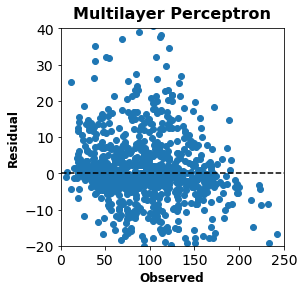

In [25]:
# residual = np.absolute(np.squeeze(y_test_nn) - y_test)
residual = np.squeeze(y_test_nn) - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[1000:2000], residual[1000:2000])
# plt.plot(range(300), range(300), '-k')
plt.axhline(y=0, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Multilayer Perceptron', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.show()
# plt.savefig('neural network Residual.png', dpi =400)

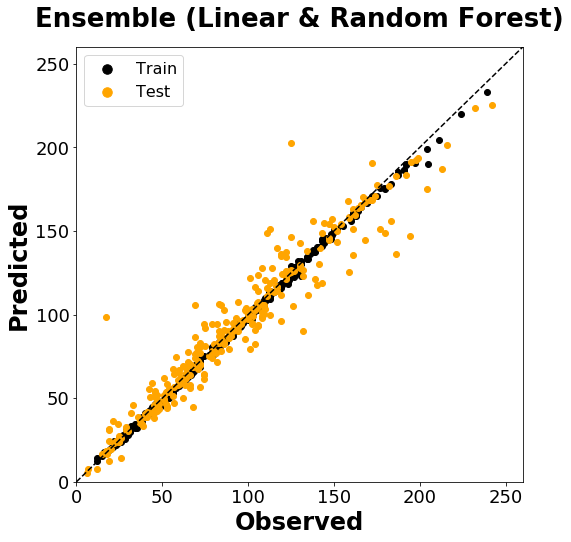

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1300], y_train_nn[1000:1300], label = 'Train', color='black')
plt.scatter(y_test[1000:1300], y_test_nn[1000:1300], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Ensemble (Linear & Random Forest)', fontsize =26, fontweight = 'bold', pad=20)
plt.xlabel('Observed',fontsize =24, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =24, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
# (prop = {'size': 20})
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
plt.show()
plt.savefig('Ensemble-VR predicted vs observed.png', dpi = 400)